# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.  
Нужно научиться определять рыночную стоимость объектов недвижимости.  
Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Открытие файла с данными и изучение общей информации. 

Импортирование библиотеки Pandas и считывание данных с записью в отдельную переменную.

In [1]:
import pandas as pd
import copy
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from pandas.plotting import andrews_curves
import missingno as msno
import warnings
warnings.simplefilter("ignore", UserWarning)
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv('C:/Users/Artem/YA_Practicum/datasets/real_estate_data.csv', sep = '\t')
start_len_data = data.shape[0] #Зафиксируем начальное количество данных/квартир
print('Начальное количество данных:',start_len_data)

Начальное количество данных: 23699


Общая гистограмма для всех числовых столбцов таблицы

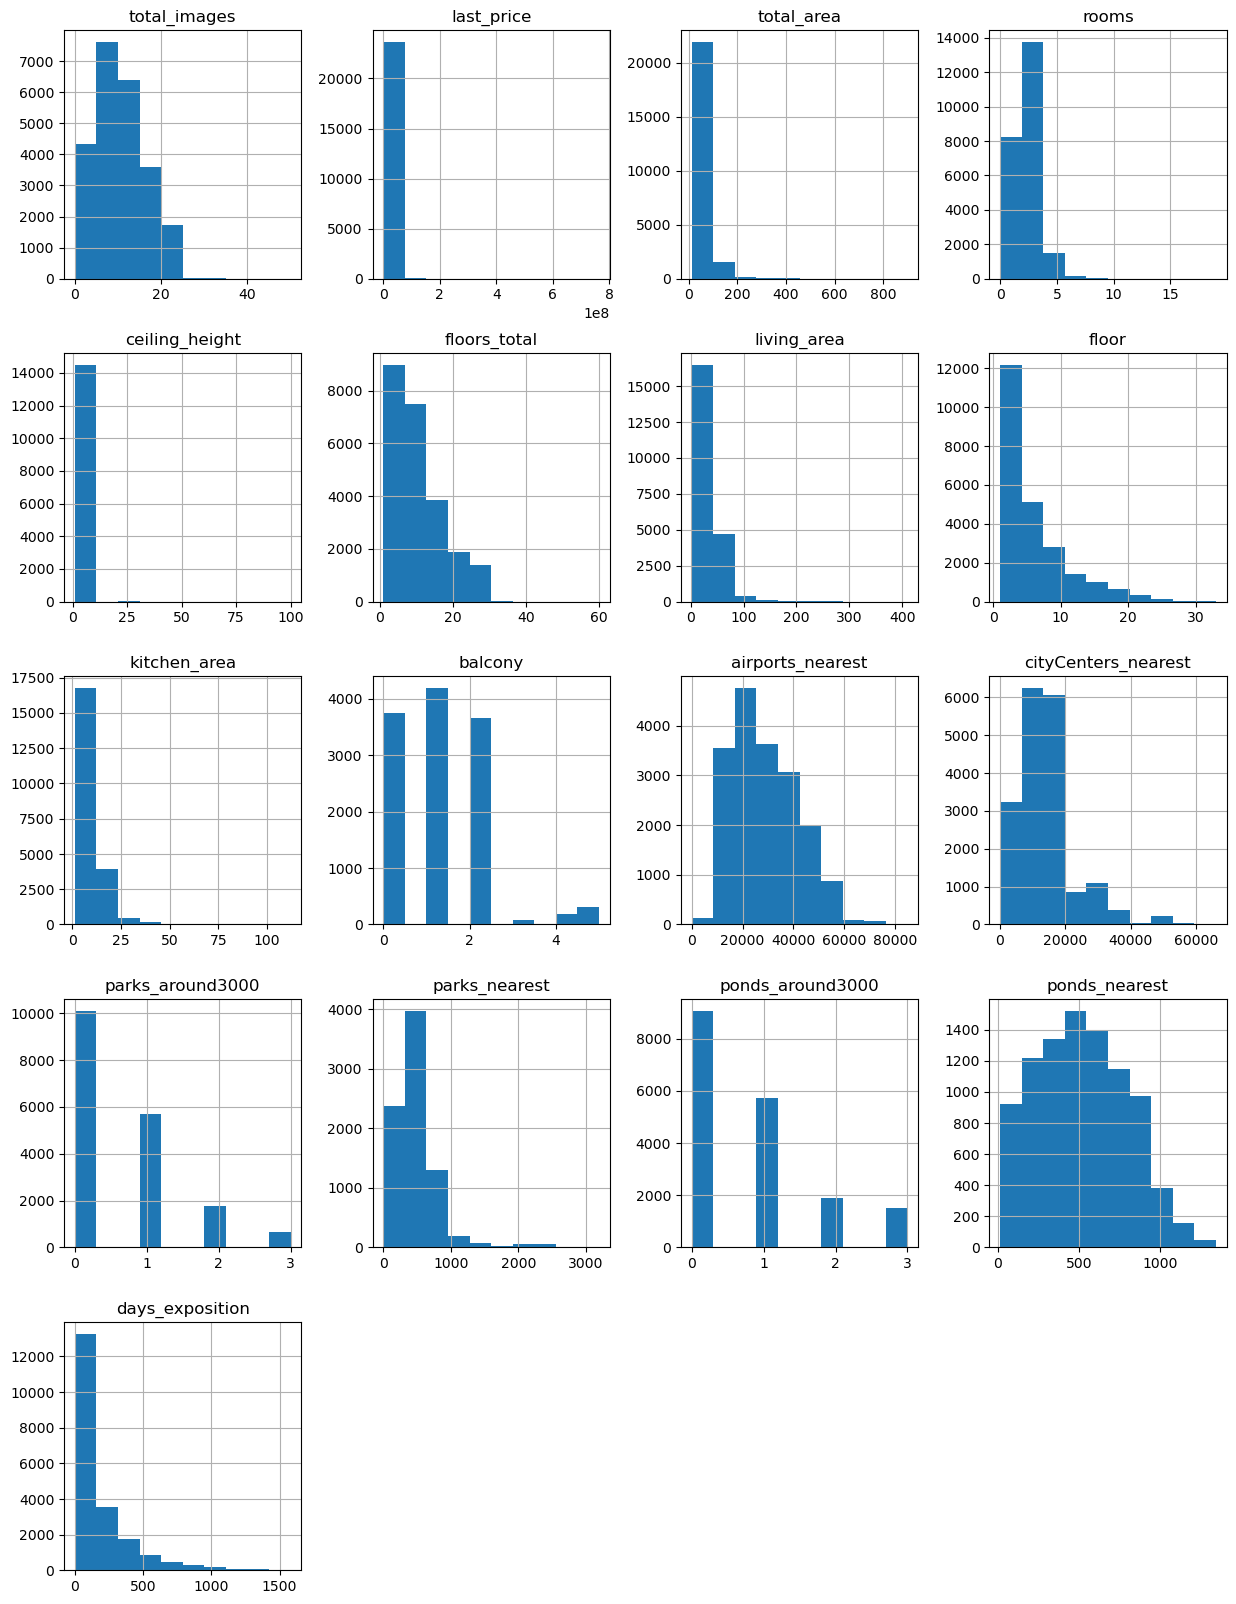

In [3]:
data.hist(figsize=(15, 20))
plt.ylabel('count', fontsize=16)
plt.show()

Выведем первые 5 строк для ознакомления с данными

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Информация по всем столбцам таблицы

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**По типу данных столбцы делятся:**  
-Категориальные: locality_name.  
-Количественные: total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, kitchen_area, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_nearest, ponds_around3000, days_exposition.  
-Логические: is_apartment, studio, open_plan.

### Предобработка данных

#### Аномалии #

Проверка аномалий в значениях столбцов total_area, kitchen_area, living_area  
Получим срез данных по суммарной площади кухни и жилой, которая оказалась больше общей:

In [6]:
bad_area_data = data.query('(kitchen_area + living_area ) > total_area') 
display(bad_area_data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,NaN,...,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,NaN,18.0,20.00,9,NaN,...,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,NaN,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
601,12,5600000.0,53.70,2017-04-18T00:00:00,2,2.50,12.0,48.30,5,NaN,...,7.00,2.0,Санкт-Петербург,50477.0,13252.0,2.0,220.0,1.0,1250.0,167.0
696,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,NaN,...,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21824,20,2450000.0,44.00,2019-02-12T00:00:00,2,27.00,2.0,38.00,2,False,...,8.60,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21868,12,2600000.0,34.30,2018-09-26T00:00:00,1,2.50,9.0,30.60,6,NaN,...,8.00,2.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,107.0
21915,14,11990000.0,91.40,2016-05-16T00:00:00,2,NaN,16.0,62.00,12,NaN,...,32.40,0.0,Санкт-Петербург,10934.0,12551.0,0.0,NaN,0.0,NaN,93.0
21956,0,5200000.0,46.00,2018-07-20T00:00:00,2,NaN,5.0,44.00,5,NaN,...,8.00,1.0,Санкт-Петербург,14103.0,15182.0,1.0,488.0,0.0,NaN,7.0


In [7]:
bad_area_data.query('kitchen_area == living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
696,1,3364930.0,34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,NaN,...,23.43,2.0,Санкт-Петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
7755,1,1811250.0,20.67,2016-03-28T00:00:00,1,2.65,24.0,14.95,13,NaN,...,14.95,1.0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,98.0
10725,12,3000000.0,25.60,2017-05-24T00:00:00,1,2.70,18.0,14.17,13,NaN,...,14.17,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,558.0
11579,7,4300000.0,33.00,2016-05-13T00:00:00,1,NaN,16.0,26.00,14,NaN,...,26.00,0.0,Санкт-Петербург,37180.0,12702.0,0.0,NaN,0.0,NaN,180.0
21266,10,8800000.0,60.00,2018-07-23T00:00:00,2,3.15,6.0,35.00,4,NaN,...,35.00,NaN,Санкт-Петербург,16558.0,8089.0,1.0,531.0,2.0,518.0,NaN


На 5ти объектах, продавцы указывают прощадь кухни как жилую. Возможно это ошибка данных при вводе.  
Удалим строки с условием kitchen_area + living_area > total_area, с помощью индексации

In [8]:
data = data.drop(bad_area_data.index)
print(data.query('(kitchen_area + living_area ) > total_area'))

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


Проверим аномальные значения высоты потолков. Потолки не могут быть ниже 2.5м **<font color="maroon">и выше 5м</font>**

In [9]:
bad_ceiling_height_data = data.query('ceiling_height > 5 or ceiling_height < 2.5')
print(f'Количество объектов с неверной высотой потолков:{len(bad_ceiling_height_data)}, это {round(len(bad_ceiling_height_data)/len(data)*100, 1)}% от всей выборки.')


Количество объектов с неверной высотой потолков:107, это 0.5% от всей выборки.


Удалим эти строки

In [10]:
data = data.drop(bad_ceiling_height_data.index)

#### Пропуски #

<Axes: >

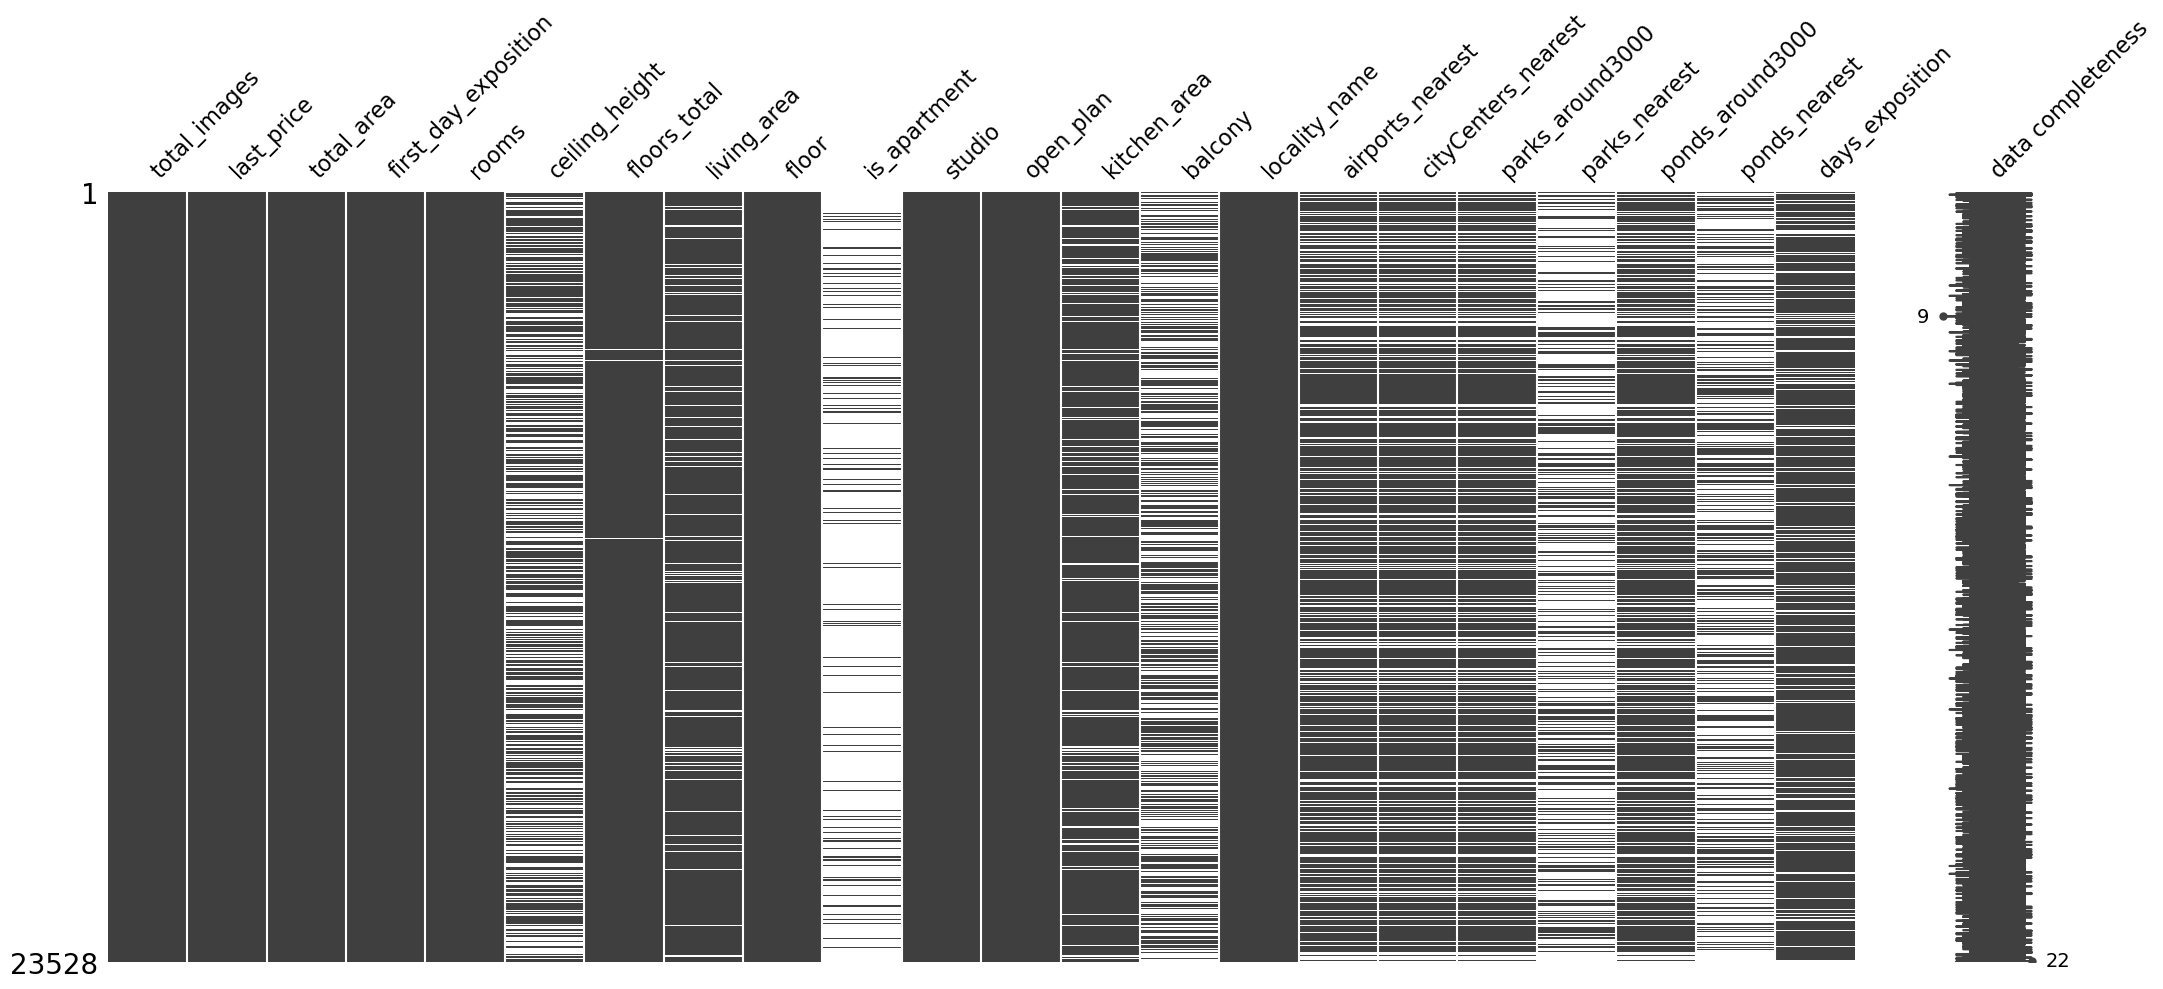

In [11]:
msno.matrix(data, labels=True)

Определим количество пропусков в каждом столбце

In [12]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9173
floors_total               86
living_area              1895
floor                       0
is_apartment            20793
studio                      0
open_plan                   0
kitchen_area             2262
balcony                 11458
locality_name              49
airports_nearest         5482
cityCenters_nearest      5459
parks_around3000         5458
parks_nearest           15508
ponds_around3000         5458
ponds_nearest           14473
days_exposition          3156
dtype: int64


**Столбцы, пропуски в которых можно восcтановить и необходимые для выставления гипотез:**  
floors_total (Пригодится для категоризации по этажам)  
living_area  (Для вычисления отношения к общей площади)  
kitchen_area (Для вычисления отношения к общей площади)  
cityCenters_nearest  (Для определения расстояния от центра Санкт-Петербурга)  
locality_name (Возможно восстановить зная значение cityCenters_nearest)  
**Столбцы не влияющие для выставления гипотез:**  
is_apartment (Не влияет на исследования, так как показывает только возможность регистрации прописки на данном объекте)  
balcony (Не влияет, но возможно восстановить пропуски)  
parks_nearest и ponds_nearest (Столбцы не имеют значения для гипотез, воозможно восстановить из столбцов parks_around3000 и ponds_around3000 соответственно)  
**Столбцы, значения которых невозможно корректно восстановить:**  
ceiling_height (Большое количество пропусков, использование средних значений и медиан будет неправильным)  
days_exposition (Нет зависимости от других столбцов)


Рассмотрим пропуски в floors_total и их зависимость с floor

In [13]:
floor_without_floors_total_data = data[data['floors_total'].isna() == True]['floor'].value_counts()
print(floor_without_floors_total_data)
data['floors_total'].value_counts()

floor
4     10
6      9
8      8
12     6
9      5
21     4
5      4
7      4
3      4
19     3
11     3
13     3
1      3
18     3
15     3
10     3
24     2
2      2
20     2
14     2
22     1
17     1
23     1
Name: count, dtype: int64


floors_total
5.0     5728
9.0     3744
16.0    1364
12.0    1351
4.0     1196
10.0    1170
25.0    1069
6.0      906
17.0     828
3.0      663
7.0      588
14.0     548
18.0     500
24.0     465
8.0      387
2.0      377
15.0     364
23.0     352
19.0     338
22.0     286
20.0     271
13.0     227
11.0     201
27.0     163
21.0     158
26.0     124
35.0      23
1.0       23
28.0      21
36.0       2
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
Name: count, dtype: int64

Пропущенные значения в 'floors_total' и значения этажа в 'floors', которые в свою очередь совпадают с уникальными значениями в  'floors_total', указывают на то, что объект недвижимости находится на последнем этаже.
Заполним пропуски 'floors_total' соответствующим значением 'floors'

In [14]:
data['floors_total'] = data['floors_total'].fillna(0)

def fill_floors_total(row):
    if row[6] == 0:
        row[6] = row[8]
    return row
data = data.apply(fill_floors_total, axis=1)

In [15]:
(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9173
floors_total                0
living_area              1895
floor                       0
is_apartment            20793
studio                      0
open_plan                   0
kitchen_area             2262
balcony                 11458
locality_name              49
airports_nearest         5482
cityCenters_nearest      5459
parks_around3000         5458
parks_nearest           15508
ponds_around3000         5458
ponds_nearest           14473
days_exposition          3156
dtype: int64

 Пропуски в living_area заполним с помошью среднего соотношения жилой площади к общей.

In [16]:
living_area_ratio_mean = (data['living_area'] / data['total_area']).mean()
data['living_area'] = data['living_area'].fillna(0)

def fill_living_area(row):
    if row[7] == 0:
        row[7] = float(format(row[2] * living_area_ratio_mean, '.2f'))
    return row

data = data.apply(fill_living_area, axis=1)

data['living_area'].isna().value_counts()

living_area
False    23528
Name: count, dtype: int64

Больше 90% пропусков в столбце 'is_apartment'. Заполнять и ориентироваться на данные по этому столбцу нет смысла.

Пропуски в kitchen_area, аналогично living_area, заполним с помошью среднего соотношения площади кухни к общей.

In [17]:
kitchen_area_ratio_mean = (data['kitchen_area'] / data['total_area']).mean()
data['kitchen_area'] = data['kitchen_area'].fillna(0)

def fill_kitchen_area(row):
    if row[7] == 0:
        row[7] = float(format(row[2] * kitchen_area_ratio_mean, '.2f'))
    return row

data = data.apply(fill_kitchen_area, axis=1)

data['kitchen_area'].isna().value_counts()

kitchen_area
False    23528
Name: count, dtype: int64

Пропуски в столбце balcony, указывает на его отсутствие, заполним их нулем.

In [18]:
data['balcony'] = data['balcony'].fillna(0)

Столбец locality_name имеет 49 пропусков, что незначительно скажется на исследовании. Удалим эти строки 

In [19]:
data.drop(data[data['locality_name'].isna()].index, inplace=True)


In [20]:
data[data['parks_around3000'].isna() == True][data['cityCenters_nearest'].isna() == True][data['airports_nearest'].isna() == True][data['parks_nearest'].isna() == True][data['locality_name'] != 'Санкт-Петербург' ]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,NaN,...,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,NaN,...,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,18.49,2,NaN,...,0.00,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23683,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,NaN,...,5.50,0.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,NaN,...,6.00,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,NaN,...,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,NaN,...,0.00,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Одинаковое количество пропусков в столбцах parks_around3000, ponds_around3000, cityCenters_nearest, airports_nearest, parks_nearest не в Санкт-Петербурге указывает на системную ошибку. 

Количество парков и прудов в районе 3км (parks_around3000 и ponds_around3000) заполним значениями 0.

In [21]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23479 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23479 non-null  int64  
 1   last_price            23479 non-null  float64
 2   total_area            23479 non-null  float64
 3   first_day_exposition  23479 non-null  object 
 4   rooms                 23479 non-null  int64  
 5   ceiling_height        14341 non-null  float64
 6   floors_total          23479 non-null  float64
 7   living_area           23479 non-null  float64
 8   floor                 23479 non-null  int64  
 9   is_apartment          2720 non-null   object 
 10  studio                23479 non-null  bool   
 11  open_plan             23479 non-null  bool   
 12  kitchen_area          23479 non-null  float64
 13  balcony               23479 non-null  float64
 14  locality_name         23479 non-null  object 
 15  airports_nearest      18

Заполнение столцов airports_nearest, cityCenters_nearest и ponds_nearest не требуется из условий гипотез.

#### Типы данных #

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23479 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23479 non-null  int64  
 1   last_price            23479 non-null  float64
 2   total_area            23479 non-null  float64
 3   first_day_exposition  23479 non-null  object 
 4   rooms                 23479 non-null  int64  
 5   ceiling_height        14341 non-null  float64
 6   floors_total          23479 non-null  float64
 7   living_area           23479 non-null  float64
 8   floor                 23479 non-null  int64  
 9   is_apartment          2720 non-null   object 
 10  studio                23479 non-null  bool   
 11  open_plan             23479 non-null  bool   
 12  kitchen_area          23479 non-null  float64
 13  balcony               23479 non-null  float64
 14  locality_name         23479 non-null  object 
 15  airports_nearest      18

Столбцы, требующие перевода в целочисленный тип данных:  
-last_price(Уровень цен на квартиры округлен до целых рублей)  
-floors_total(В домах небывает неполных этажей)  
-balcony, parks_around3000, ponds_around3000(Количество может быть только целым)  
-airports_nearest, cityCenters_nearest, parks_nearest и ponds_nearest(расстояния указаны в метрах)

In [23]:
columns_to_int = ['last_price','floors_total','balcony','airports_nearest','cityCenters_nearest','parks_nearest','ponds_nearest','parks_around3000','ponds_around3000','days_exposition']
for col in columns_to_int:
    data[col] = pd.to_numeric(data[col], downcast='integer')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23479 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23479 non-null  int64  
 1   last_price            23479 non-null  int32  
 2   total_area            23479 non-null  float64
 3   first_day_exposition  23479 non-null  object 
 4   rooms                 23479 non-null  int64  
 5   ceiling_height        14341 non-null  float64
 6   floors_total          23479 non-null  int8   
 7   living_area           23479 non-null  float64
 8   floor                 23479 non-null  int64  
 9   is_apartment          2720 non-null   object 
 10  studio                23479 non-null  bool   
 11  open_plan             23479 non-null  bool   
 12  kitchen_area          23479 non-null  float64
 13  balcony               23479 non-null  int8   
 14  locality_name         23479 non-null  object 
 15  airports_nearest      18

airports_nearest, cityCenters_nearest, parks_nearest и ponds_nearest невозможно преобразовать так как они имеют пропуски.

Так как в столбце first_day_exposition нет указания по времени, создадим новый столбец только с данными по дате.

In [24]:
data['date'] =  pd.to_datetime(data['first_day_exposition']).dt.date
data.head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,date
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16,51.00,8,NaN,...,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,2019-03-07
1,7,3350000,40.40,2018-12-04T00:00:00,1,NaN,11,18.60,1,NaN,...,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,2018-12-04
2,10,5196000,56.00,2015-08-20T00:00:00,2,NaN,5,34.30,4,NaN,...,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,2015-08-20
3,0,64900000,159.00,2015-07-24T00:00:00,3,NaN,14,89.64,9,NaN,...,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,2015-07-24
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.00,13,NaN,...,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,2018-06-19
5,10,2890000,30.40,2018-09-10T00:00:00,1,NaN,12,14.40,5,NaN,...,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,2018-09-10
6,6,3700000,37.30,2017-11-02T00:00:00,1,NaN,26,10.60,6,NaN,...,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,2017-11-02
7,5,7915000,71.60,2019-04-18T00:00:00,2,NaN,24,40.37,22,NaN,...,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN,2019-04-18
8,20,2900000,33.16,2018-05-23T00:00:00,1,NaN,27,15.43,26,NaN,...,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189.0,2018-05-23
9,18,5400000,61.00,2017-02-26T00:00:00,3,2.50,9,43.60,7,NaN,...,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,2017-02-26


#### Дубликаты #

In [25]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Избавимся от неявных дубликатов в столбце locality_name. тк наименование населенных пунктов начинаются с заглавной буквы, создадим новый столбец с этим наименованием.

In [26]:
data_copy = copy.deepcopy(data)

bad_locality_name = data_copy[data_copy['locality_name'].isna()]
data_copy.drop(bad_locality_name.index, inplace=True)

def make_short_name(row):
    split_name = row.split()
    new_name = []
    for word in split_name:
        if word[0].isupper():
            new_name.append(word)
    new_name = ' '.join(word for word in new_name)
    return new_name
   
data['short_locality_name'] = data_copy['locality_name'].apply(make_short_name)
data.head(20)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,date,short_locality_name
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.70,16,51.00,8,NaN,...,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,2019-03-07,Санкт-Петербург
1,7,3350000,40.40,2018-12-04T00:00:00,1,NaN,11,18.60,1,NaN,...,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,2018-12-04,Шушары
2,10,5196000,56.00,2015-08-20T00:00:00,2,NaN,5,34.30,4,NaN,...,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,2015-08-20,Санкт-Петербург
3,0,64900000,159.00,2015-07-24T00:00:00,3,NaN,14,89.64,9,NaN,...,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,2015-07-24,Санкт-Петербург
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.03,14,32.00,13,NaN,...,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,2018-06-19,Санкт-Петербург
5,10,2890000,30.40,2018-09-10T00:00:00,1,NaN,12,14.40,5,NaN,...,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,2018-09-10,Янино-1
6,6,3700000,37.30,2017-11-02T00:00:00,1,NaN,26,10.60,6,NaN,...,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,2017-11-02,Парголово
7,5,7915000,71.60,2019-04-18T00:00:00,2,NaN,24,40.37,22,NaN,...,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN,2019-04-18,Санкт-Петербург
8,20,2900000,33.16,2018-05-23T00:00:00,1,NaN,27,15.43,26,NaN,...,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189.0,2018-05-23,Мурино
9,18,5400000,61.00,2017-02-26T00:00:00,3,2.50,9,43.60,7,NaN,...,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,2017-02-26,Санкт-Петербург


Избавимся от явных дубликатов

In [27]:
data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23479 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23479 non-null  int64  
 1   last_price            23479 non-null  int32  
 2   total_area            23479 non-null  float64
 3   first_day_exposition  23479 non-null  object 
 4   rooms                 23479 non-null  int64  
 5   ceiling_height        14341 non-null  float64
 6   floors_total          23479 non-null  int8   
 7   living_area           23479 non-null  float64
 8   floor                 23479 non-null  int64  
 9   is_apartment          2720 non-null   object 
 10  studio                23479 non-null  bool   
 11  open_plan             23479 non-null  bool   
 12  kitchen_area          23479 non-null  float64
 13  balcony               23479 non-null  int8   
 14  locality_name         23479 non-null  object 
 15  airports_nearest      18

In [28]:
print('Количество значений до обработки:',start_len_data)
print('Количество значений после обработки:',data.shape[0])
print('Процент удаленных данных:', '{:.2%}'.format((start_len_data - data.shape[0])/start_len_data))

Количество значений до обработки: 23699
Количество значений после обработки: 23479
Процент удаленных данных: 0.93%


**<font color="maroon"> Промежуточный вывод  </font>**
  
    В ходе преодобрабоки данных:  
    1.Были заполнены пропуски.  
    2.Было выполнено удаление дубликатов и значений, пустоты которых не возможно было заполнить.  
    3.Был изменен тип данных для комфортного восприятия информации.  
    В ходе предобработки исходный размер данных уменьшился на 0.93%. 

### Посчитаем и добавим в таблицу новые столбцы

Посчитаем цену за квадратный метр и добавим новый столбец price_per_square_meter

In [29]:
data['price_per_square_meter'] =(data['last_price'] / data['total_area'] * 100).round()/100
data['price_per_square_meter']

0        120370.37
1         82920.79
2         92785.71
3        408176.10
4        100000.00
           ...    
23694     72490.85
23695     52542.37
23696     44091.71
23697    149511.40
23698     41795.67
Name: price_per_square_meter, Length: 23479, dtype: float64

In [30]:
data['weekday'] = data['date']
data['month'] = data['date']
data['year'] = data['date']

def make_weekday_month_year(row):
    row[25] = row[22].weekday()
    row[26] = row[22].month
    row[27] = row[22].year
    return row

data = data.apply(make_weekday_month_year,axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,date,short_locality_name,price_per_square_meter,weekday,month,year
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.00,8,NaN,...,482.0,2,755.0,NaN,2019-03-07,Санкт-Петербург,120370.37,3,3,2019
1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11,18.60,1,NaN,...,NaN,0,NaN,81.0,2018-12-04,Шушары,82920.79,1,12,2018
2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5,34.30,4,NaN,...,90.0,2,574.0,558.0,2015-08-20,Санкт-Петербург,92785.71,3,8,2015
3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14,89.64,9,NaN,...,84.0,3,234.0,424.0,2015-07-24,Санкт-Петербург,408176.10,4,7,2015
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.00,13,NaN,...,112.0,1,48.0,121.0,2018-06-19,Санкт-Петербург,100000.00,1,6,2018


Добавим категории этажей квартир

In [31]:
def cat_floor(row):
    if row[8] == 1:
        return 'первый'
    elif row[8] == row[6]:
        return 'последний'
    else:
        return 'другой'    
data['floor_cat'] = data.apply(cat_floor,axis=1)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,date,short_locality_name,price_per_square_meter,weekday,month,year,floor_cat
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.00,8,NaN,...,2,755.0,NaN,2019-03-07,Санкт-Петербург,120370.37,3,3,2019,другой
1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11,18.60,1,NaN,...,0,NaN,81.0,2018-12-04,Шушары,82920.79,1,12,2018,первый
2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5,34.30,4,NaN,...,2,574.0,558.0,2015-08-20,Санкт-Петербург,92785.71,3,8,2015,другой
3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14,89.64,9,NaN,...,3,234.0,424.0,2015-07-24,Санкт-Петербург,408176.10,4,7,2015,другой
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.00,13,NaN,...,1,48.0,121.0,2018-06-19,Санкт-Петербург,100000.00,1,6,2018,другой


Добавим столбец с расстоянием до центра города в километрах. Тип данных в столбце нельзя изменить на целочисленный так как есть пропуски. 

In [32]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,date,short_locality_name,price_per_square_meter,weekday,month,year,floor_cat,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.00,8,NaN,...,755.0,NaN,2019-03-07,Санкт-Петербург,120370.37,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11,18.60,1,NaN,...,NaN,81.0,2018-12-04,Шушары,82920.79,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5,34.30,4,NaN,...,574.0,558.0,2015-08-20,Санкт-Петербург,92785.71,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14,89.64,9,NaN,...,234.0,424.0,2015-07-24,Санкт-Петербург,408176.10,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.00,13,NaN,...,48.0,121.0,2018-06-19,Санкт-Петербург,100000.00,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных

Построем гистограммы для площадей, цены, числа комнат, высот потолков

#### Общая площадь #

Text(0, 0.5, 'Количество объектов, шт')

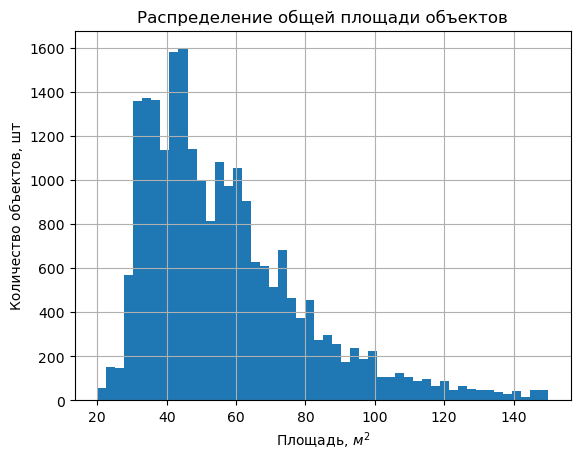

In [33]:
data['total_area'].hist(bins=50, range = (20, 150))
plt.title('Распределение общей площади объектов')
plt.xlabel('Площадь, $м^2$')
plt.ylabel('Количество объектов, шт')

In [34]:
data['total_area'].describe()

count    23479.000000
mean        60.362728
std         35.603498
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

Больше всех квартир находяться в районе от 40 до 50 кв.м. 

#### Жилая площадь #

Text(0, 0.5, 'Количество объектов, шт')

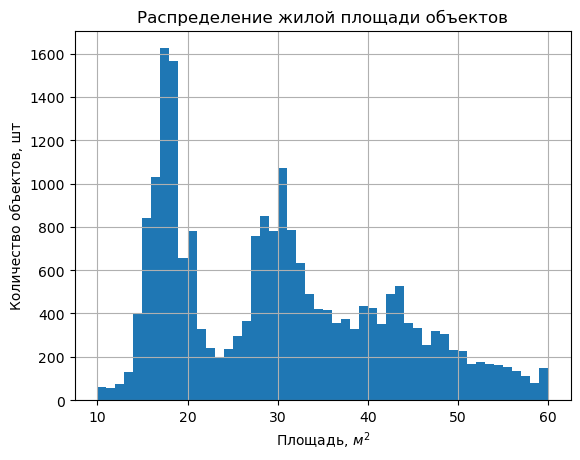

In [35]:
data['living_area'].hist(bins=50, range = (10, 60))
plt.title('Распределение жилой площади объектов')
plt.xlabel('Площадь, $м^2$')
plt.ylabel('Количество объектов, шт')

In [36]:
data['living_area'].describe()

count    23479.000000
mean        34.520124
std         22.289050
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

Наибольшие количество объявлений с жилой площадью 18 и 30 кв.м, говорят о большом количестве студий и однокомнатных квартир.

#### Площадь кухни #

Text(0, 0.5, 'Количество объектов, шт')

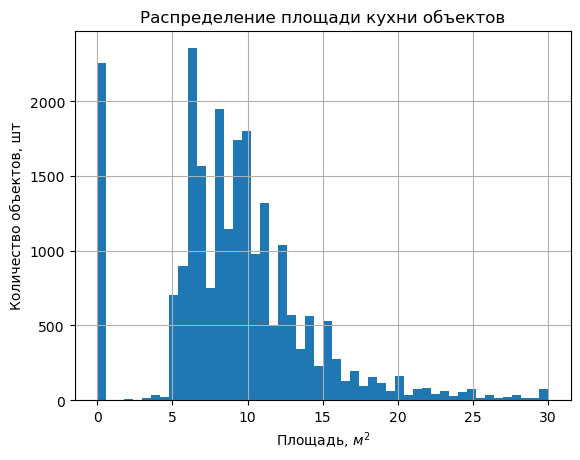

In [37]:
data['kitchen_area'].hist(bins=50, range = (0, 30))
plt.title('Распределение площади кухни объектов')
plt.xlabel('Площадь, $м^2$')
plt.ylabel('Количество объектов, шт')

In [38]:
data['kitchen_area'].describe()

count    23479.000000
mean         9.547020
std          6.400452
min          0.000000
25%          6.300000
50%          9.000000
75%         11.400000
max        112.000000
Name: kitchen_area, dtype: float64

Выбросы больших значений у 0 говорят о популярности студий.

#### Стоимость объекта #

Text(0, 0.5, 'Количество объектов, шт')

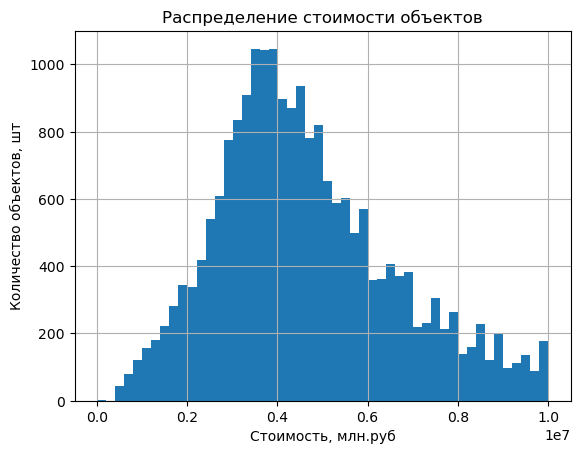

In [39]:
data['last_price'].hist(bins=50, range = (12000, 10000000))
plt.title('Распределение стоимости объектов')
plt.xlabel('Стоимость, млн.руб')
plt.ylabel('Количество объектов, шт')

In [40]:
data['last_price'].describe()

count    2.347900e+04
mean     6.538408e+06
std      1.085021e+07
min      1.219000e+04
25%      3.430000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

График имеет форму нормального распределения. Наиболее распространены квартиры стоимостью 4,65 млн руб.

#### Количество комнат #

Text(0, 0.5, 'Количество объектов, шт')

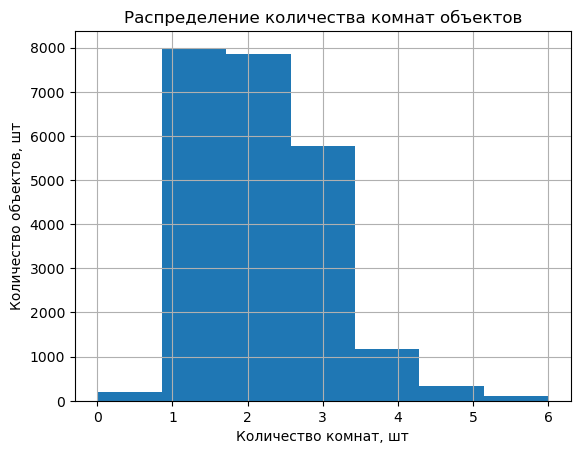

In [41]:
data['rooms'].hist(bins=7, range = (0, 6))
plt.title('Распределение количества комнат объектов')
plt.xlabel('Количество комнат, шт')
plt.ylabel('Количество объектов, шт')

In [42]:
data['rooms'].describe()

count    23479.000000
mean         2.071127
std          1.079418
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Из графика видно что в выборке преобладают однокомнатные квартиры. 

#### Высота потолков #

Text(0, 0.5, 'Количество объектов, шт')

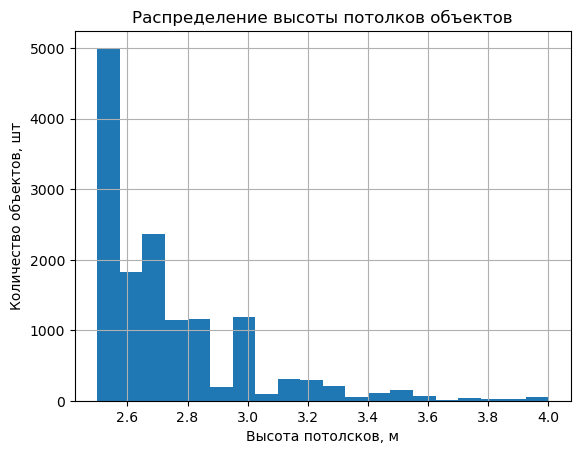

In [43]:
data['ceiling_height'].hist(bins=20, range = (2.5, 4))
plt.title('Распределение высоты потолков объектов')
plt.xlabel('Высота потолсков, м')
plt.ylabel('Количество объектов, шт')

In [44]:
data['ceiling_height'].describe()

count    14341.000000
mean         2.726924
std          0.270539
min          2.500000
25%          2.520000
50%          2.650000
75%          2.800000
max          5.000000
Name: ceiling_height, dtype: float64

Большинство квартир с высотой потолков 2,65м

#### Этаж квартиры #

Text(0, 0.5, 'Количество объектов, шт')

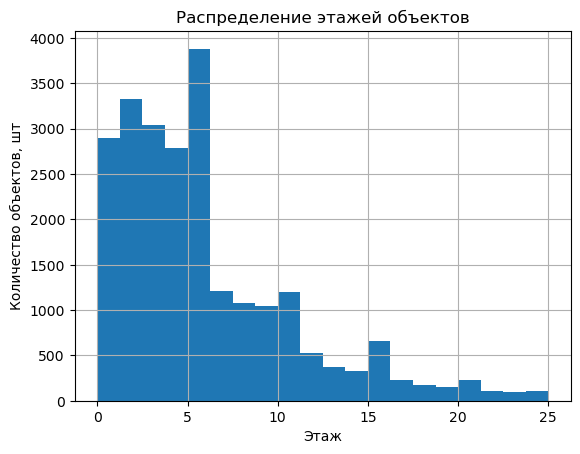

In [45]:
data['floor'].hist(bins=20, range = (0, 25))
plt.title('Распределение этажей объектов')
plt.xlabel('Этаж')
plt.ylabel('Количество объектов, шт')

In [46]:
data['floor'].describe()

count    23479.000000
mean         5.893479
std          4.884746
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Большая часть квартир находятся до 5 этажа.

#### Категория этажа #

Text(0, 0.5, 'Количество объектов, шт')

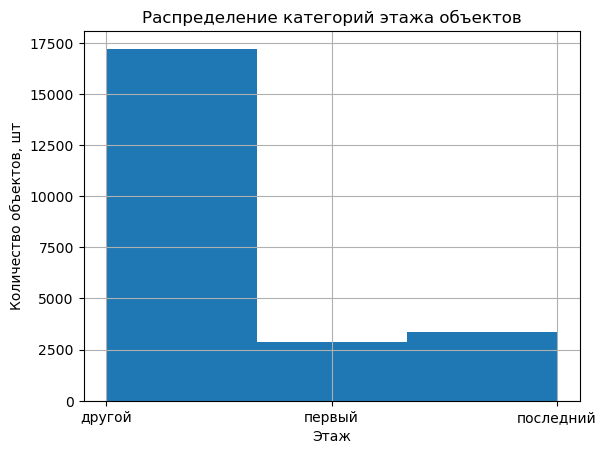

In [47]:
data['floor_cat'].hist(bins=3)
plt.title('Распределение категорий этажа объектов')
plt.xlabel('Этаж')
plt.ylabel('Количество объектов, шт')

In [48]:
data['floor_cat'].describe()

count      23479
unique         3
top       другой
freq       17213
Name: floor_cat, dtype: object

Количество объектов на последнем этаже незначительно превышает объекты на первом.

#### Этажность #

Text(0, 0.5, 'Количество объектов, шт')

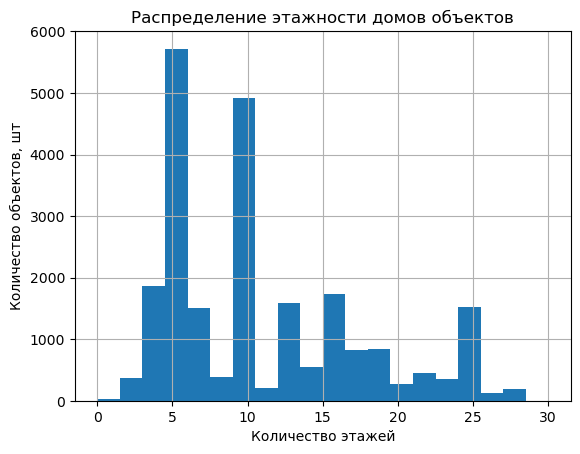

In [49]:
data['floors_total'].hist(bins=20, range = (0, 30))
plt.title('Распределение этажности домов объектов')
plt.xlabel('Количество этажей')
plt.ylabel('Количество объектов, шт')

In [50]:
data['floors_total'].describe()

count    23479.000000
mean        10.680395
std          6.590138
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Из гистограммы видно большое количество объектов типовой застройки. 5ти и 9ти этажные дома.

#### Расстояние до центра #

Text(0, 0.5, 'Количество объектов, шт')

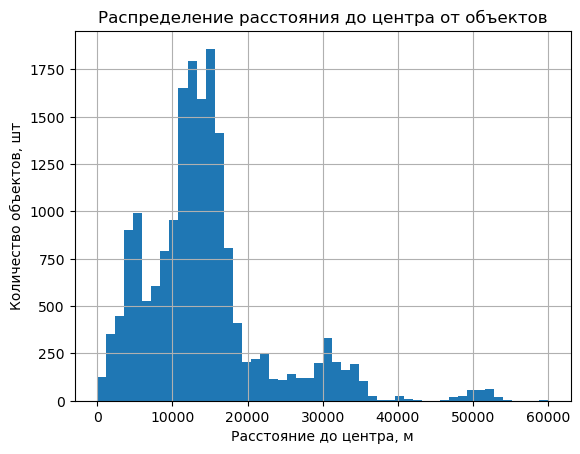

In [51]:
data['cityCenters_nearest'].hist(bins=50, range = (0, 60000))
plt.title('Распределение расстояния до центра от объектов')
plt.xlabel('Расстояние до центра, м')
plt.ylabel('Количество объектов, шт')

In [52]:
data['cityCenters_nearest'].describe()

count    18028.00000
mean     14197.74351
std       8608.27094
min        181.00000
25%       9241.00000
50%      13104.50000
75%      16293.00000
max      65968.00000
Name: cityCenters_nearest, dtype: float64

Среднее расстояние до центра 14км 

#### Близость аэропорта #

Text(0, 0.5, 'Количество объектов, шт')

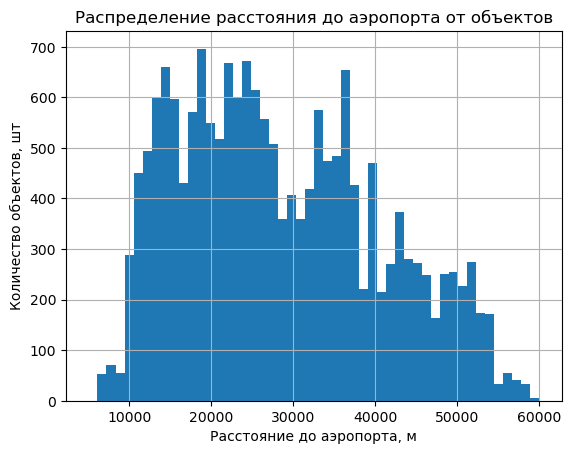

In [53]:
data['airports_nearest'].hist(bins=50, range = (5000, 60000))
plt.title('Распределение расстояния до аэропорта от объектов')
plt.xlabel('Расстояние до аэропорта, м')
plt.ylabel('Количество объектов, шт')

In [54]:
data['airports_nearest'].describe()

count    18005.000000
mean     28810.223049
std      12637.559295
min          0.000000
25%      18578.000000
50%      26758.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Среднее расстояние до аэропорта 29км

#### Близость парков #

Text(0, 0.5, 'Количество объектов, шт')

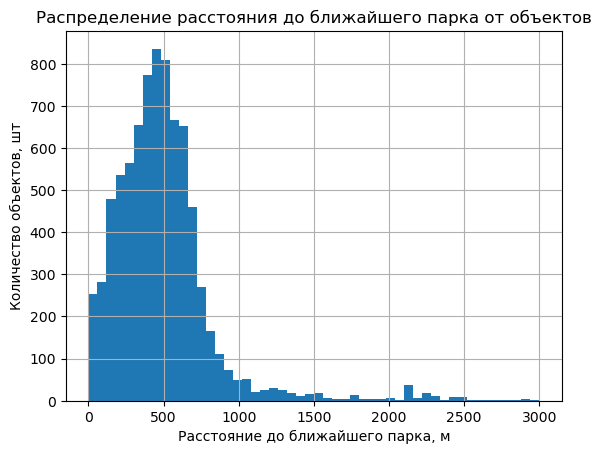

In [55]:
data['parks_nearest'].hist(bins=50, range = (0, 3000))
plt.title('Распределение расстояния до ближайшего парка от объектов')
plt.xlabel('Расстояние до ближайшего парка, м')
plt.ylabel('Количество объектов, шт')

In [56]:
data['parks_nearest'].describe()

count    8005.000000
mean      491.047220
std       342.780601
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Среднее расстояние до ближайшего парка 500м

#### День и месяц публикации объявления #

Text(0, 0.5, 'Количество объектов, шт')

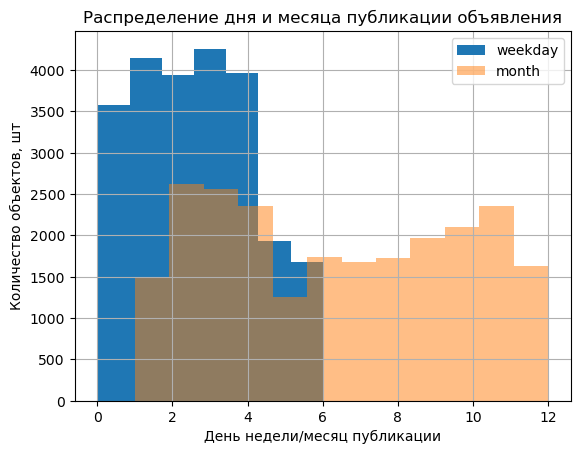

In [57]:
data['weekday'].hist(bins=7)
data['month'].hist(bins=12, alpha=0.5)
plt.legend(['weekday','month'])
plt.title('Распределение дня и месяца публикации объявления')
plt.xlabel('День недели/месяц публикации')
plt.ylabel('Количество объектов, шт')

Объявления размещались в основном в будние дни, по большей части в зимние месяцы.

#### Время продажи квартиры #

count    20324.000000
mean       180.896772
std        220.040369
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

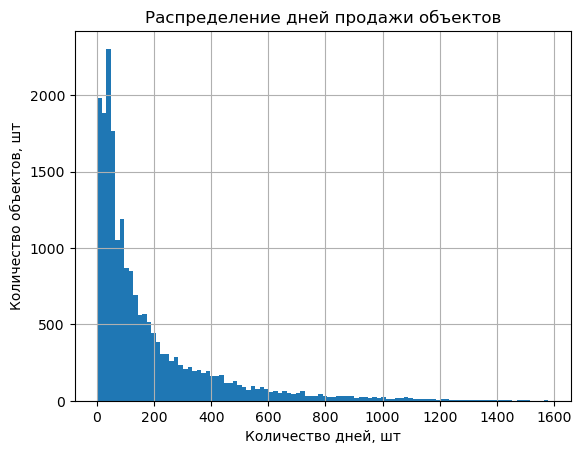

In [58]:
data['days_exposition'].hist(bins=100)
plt.title('Распределение дней продажи объектов')
plt.xlabel('Количество дней, шт')
plt.ylabel('Количество объектов, шт')
data['days_exposition'].describe()

Text(0, 0.5, 'Количество объектов, шт')

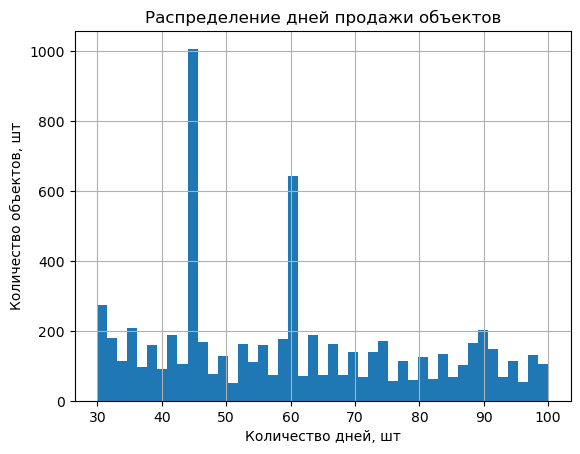

In [59]:
data['days_exposition'].hist(bins=45, range=(30,100))
plt.title('Распределение дней продажи объектов')
plt.xlabel('Количество дней, шт')
plt.ylabel('Количество объектов, шт')

Выбивающиеся значения на графике, в эти дни система убирает с показа бесплатные объявления. 

Text(0, 0.5, 'Количество объектов, шт')

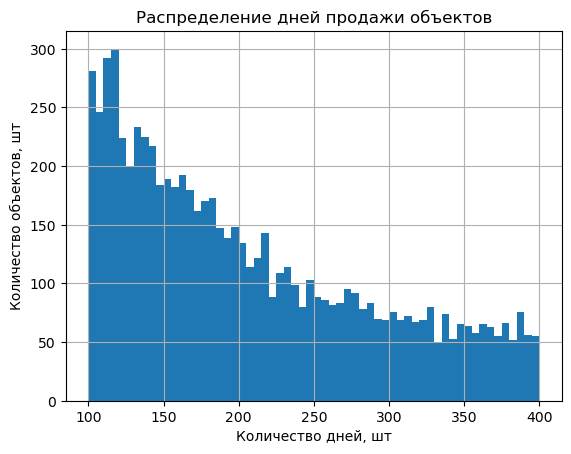

In [60]:
data['days_exposition'].hist(bins=60, range=(100,400))
plt.title('Распределение дней продажи объектов')
plt.xlabel('Количество дней, шт')
plt.ylabel('Количество объектов, шт')

Среднее значение - 180 дней. 
Медианное - 95 дней. 
Обычно квартира продается за 1-4 месяца.  
Быстрые продажи -  до 7 дней. Необычно долгие продажи те, которые длятся больше года (360 дней).

#### Стоимость квартиры #

##### Факторы больше всего влияющие на общую (полную) стоимость объекта  #
На стоимость квартиры, в основном, влияет расположение от центра города, площадь, количество комнат, инфраструктура.  
##### Зависимость цены от площадей и количества комнат:   #


In [61]:
pivot_data = data.loc[:,['price_per_square_meter', 'total_area', 'kitchen_area', 'living_area', 'rooms']]
pivot_data.head()

,price_per_square_meter,total_area,kitchen_area,living_area,rooms
0,120370.37,108.0,25.0,51.00,3
1,82920.79,40.4,11.0,18.60,1
2,92785.71,56.0,8.3,34.30,2
3,408176.10,159.0,0.0,89.64,3
4,100000.00,100.0,41.0,32.00,2


In [62]:
pivot_data.corr()

,price_per_square_meter,total_area,kitchen_area,living_area,rooms
price_per_square_meter,1.000000,0.300824,0.312109,0.229732,0.054513
total_area,0.300824,1.000000,0.515969,0.946038,0.759408
kitchen_area,0.312109,0.515969,1.000000,0.371351,0.256866
living_area,0.229732,0.946038,0.371351,1.000000,0.829584
rooms,0.054513,0.759408,0.256866,0.829584,1.000000


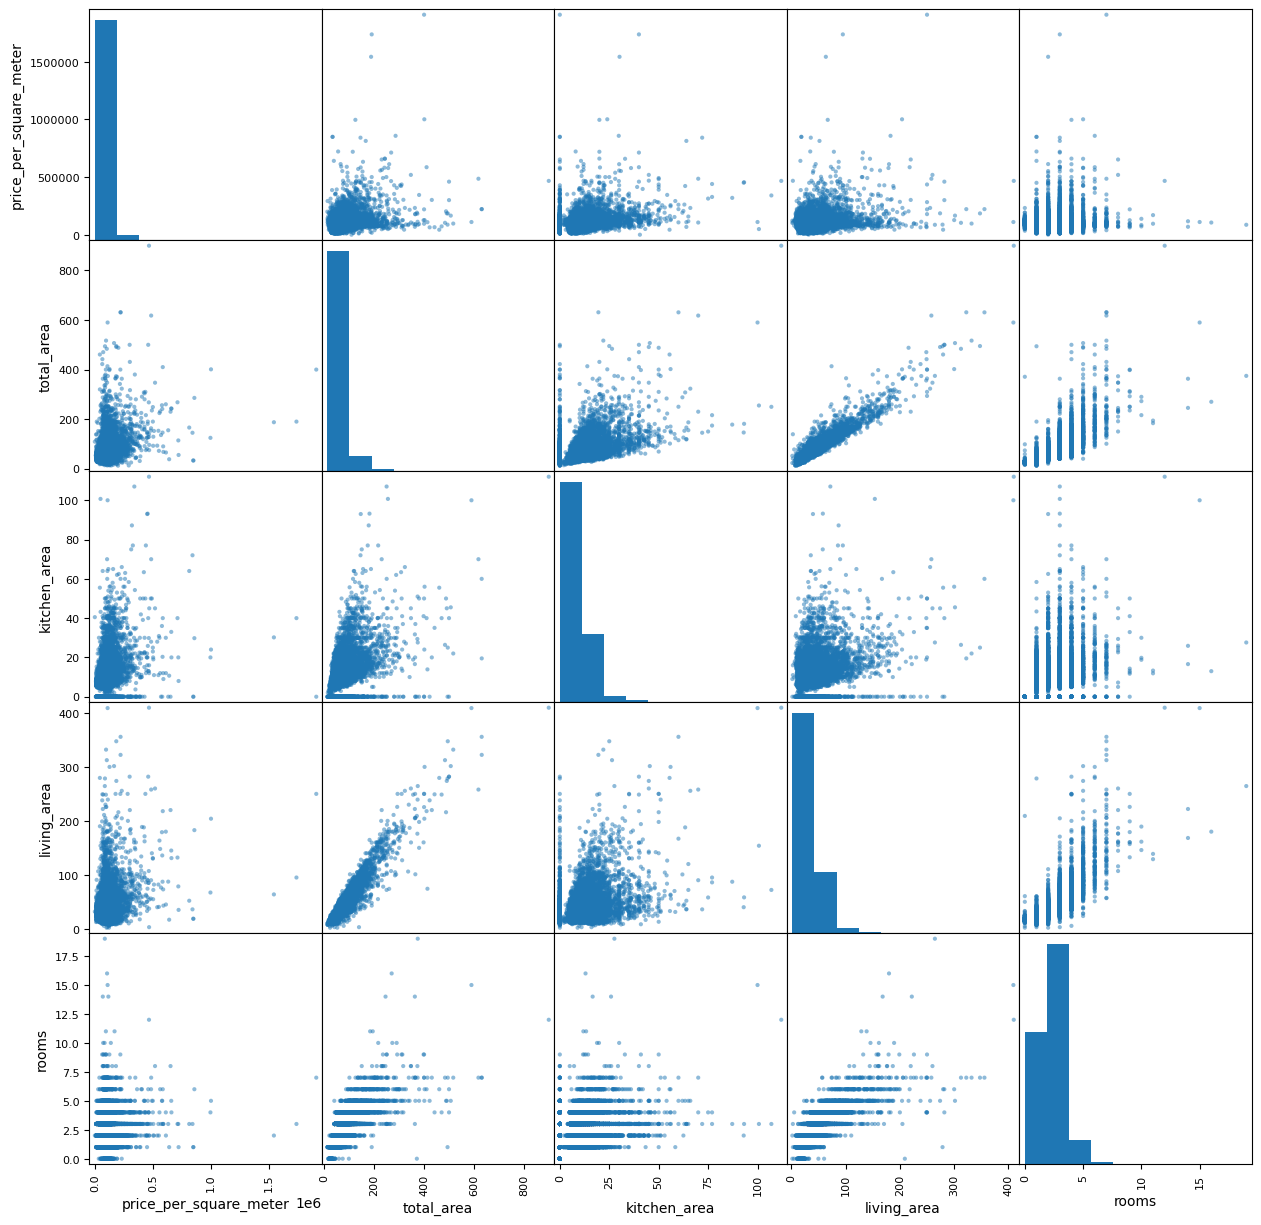

In [63]:
pd.plotting.scatter_matrix(pivot_data, figsize=(15, 15))
pd.options.mode.chained_assignment = None

Цена за квадратный метр имеет слабую зависимость от количества комнат и жилой площади.Количество комнат слабо влияет на стоимость. Комнаты и жилая площадь напрямую определяют размер общей площади. Самые распространенные квартиры имеют от 1 до 3 комнат.


##### Зависимость цены от того, на каком этаже расположена квартира. #

count      2893.000000
mean      82019.828873
std       38218.702361
min        9615.380000
25%       61111.110000
50%       81250.000000
75%       98338.870000
max      813253.010000
Name: price_per_square_meter, dtype: float64

Text(0, 0.5, 'Количество объектов, шт')

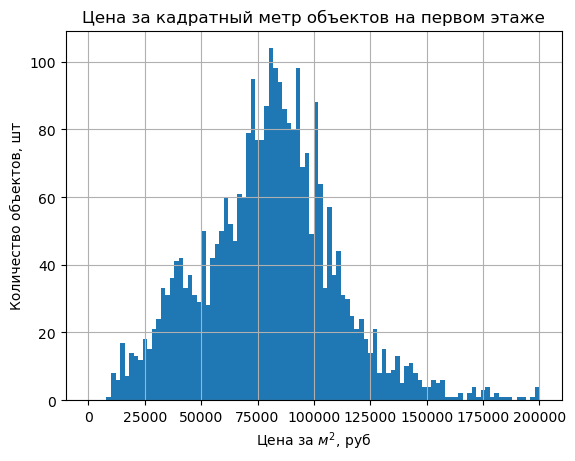

In [64]:
display(data[data['floor_cat'] == 'первый']['price_per_square_meter'].describe())
data[data['floor_cat'] == 'первый']['price_per_square_meter'].hist(bins=100, range=(0,200000))
plt.title('Цена за кадратный метр объектов на первом этаже')
plt.xlabel('Цена за $м^2$, руб')
plt.ylabel('Количество объектов, шт')

count    3.373000e+03
mean     9.332821e+04
std      6.499665e+04
min      1.118300e+02
25%      6.582734e+04
50%      8.806818e+04
75%      1.083333e+05
max      1.907500e+06
Name: price_per_square_meter, dtype: float64


Text(0, 0.5, 'Количество объектов, шт')

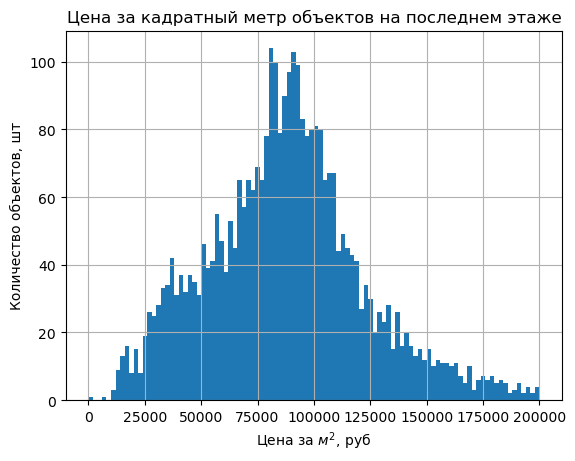

In [65]:
print(data[data['floor_cat'] == 'последний']['price_per_square_meter'].describe())
data[data['floor_cat'] == 'последний']['price_per_square_meter'].hist(bins=100, range=(0,200000))
plt.title('Цена за кадратный метр объектов на последнем этаже')
plt.xlabel('Цена за $м^2$, руб')
plt.ylabel('Количество объектов, шт')

count    1.721300e+04
mean     1.035481e+05
std      4.772113e+04
min      1.036866e+04
25%      8.116279e+04
50%      9.830508e+04
75%      1.173246e+05
max      1.736842e+06
Name: price_per_square_meter, dtype: float64

Text(0, 0.5, 'Количество объектов, шт')

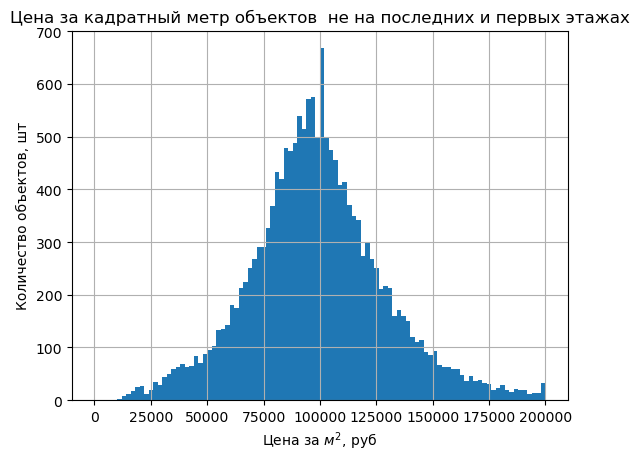

In [66]:
display(data[data['floor_cat'] == 'другой']['price_per_square_meter'].describe())
data[data['floor_cat'] == 'другой']['price_per_square_meter'].hist(bins=100, range=(0,200000))
plt.title('Цена за кадратный метр объектов  не на последних и первых этажах')
plt.xlabel('Цена за $м^2$, руб')
plt.ylabel('Количество объектов, шт')

Основные продажи квартир на других этажах проходят в районе от 80 тыс. за кв.м. до 117 тыс. за кв.м. и идет на спад. Другие этажи стоят дороже, чем первые. Их стоимость выше от квартир на последнем этаже, но нет так сильно. Стоимость квартиры не на первом и не на последнем этаже больше.

##### Зависимость от даты размещения: дня недели, месяца и года. #

In [67]:
data_weekday_month_year = data.loc[:,['price_per_square_meter', 'weekday', 'month', 'year']]
data_weekday_month_year.head()

,price_per_square_meter,weekday,month,year
0,120370.37,3,3,2019
1,82920.79,1,12,2018
2,92785.71,3,8,2015
3,408176.10,4,7,2015
4,100000.00,1,6,2018


In [68]:
data_weekday_month_year.corr()

,price_per_square_meter,weekday,month,year
price_per_square_meter,1.000000,-0.006658,-0.002558,0.009384
weekday,-0.006658,1.000000,0.011734,-0.003608
month,-0.002558,0.011734,1.000000,-0.271137
year,0.009384,-0.003608,-0.271137,1.000000


Матрица корреляции имеет слабые зависимости

###### Зависимость продаж от дня недели #

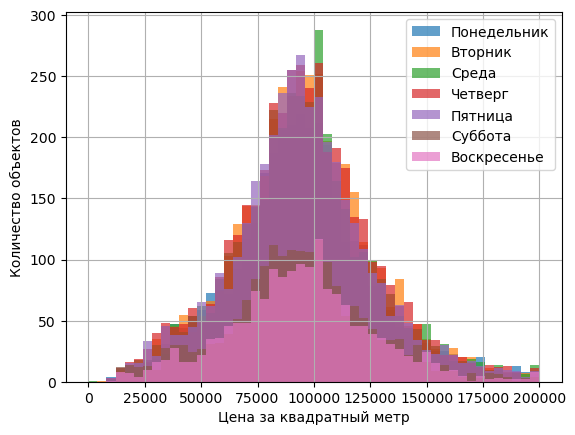

In [69]:
weekday = 0
while weekday < 7:
    data_weekday_month_year[data_weekday_month_year['weekday'] == weekday]['price_per_square_meter'].hist(stacked=True, bins=50, range=(0,200000), alpha=0.7)
    weekday += 1
plt.xlabel('Цена за квадратный метр')
plt.ylabel('Количество объектов')
plt.legend(['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресенье'])   

Text(0.5, 0, 'День недели')

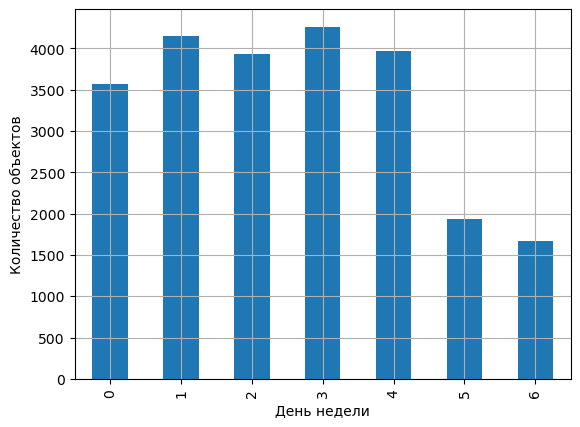

In [70]:
data_weekday_month_year.pivot_table(index='weekday', values='price_per_square_meter', aggfunc=['count']).plot(kind='bar',grid=True, legend = False)
plt.ylabel('Количество объектов')
plt.xlabel('День недели')

Cтоимость квартиры не зависит от дня продажи. Количество проданных квартир значительно меньше в выходные дни

###### Зависимость от месяца #

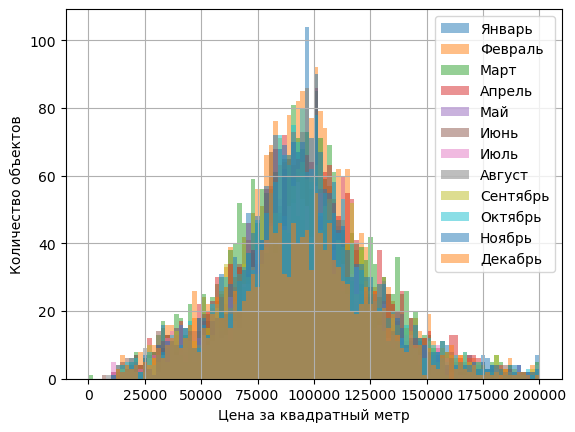

In [71]:
month = 1
while month < 13:
    data_weekday_month_year[data_weekday_month_year['month'] == month]['price_per_square_meter'].hist(bins=100, range=(0,200000), alpha=0.5)
    month += 1
plt.xlabel('Цена за квадратный метр')
plt.ylabel('Количество объектов')
plt.legend(['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'])

Text(0.5, 0, 'Месяц')

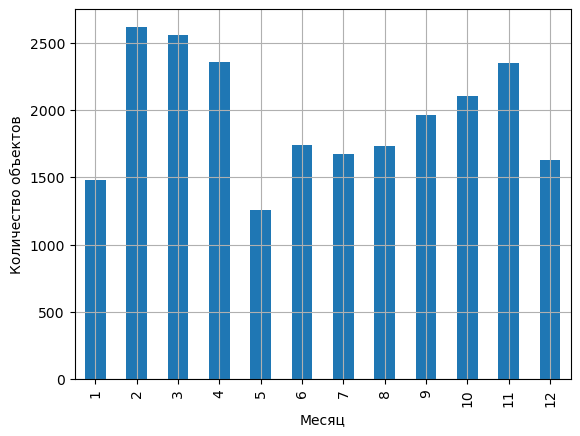

In [72]:
data_weekday_month_year.pivot_table(index='month', values='price_per_square_meter', aggfunc=['count']).plot(kind='bar',grid=True, legend = False)
plt.ylabel('Количество объектов')
plt.xlabel('Месяц')

**<font color="maroon">Отличается количество продаж в мае, декабре и январе. В эти месяцы меньше всего продаж квартир.</font>**

###### Зависимость от года #

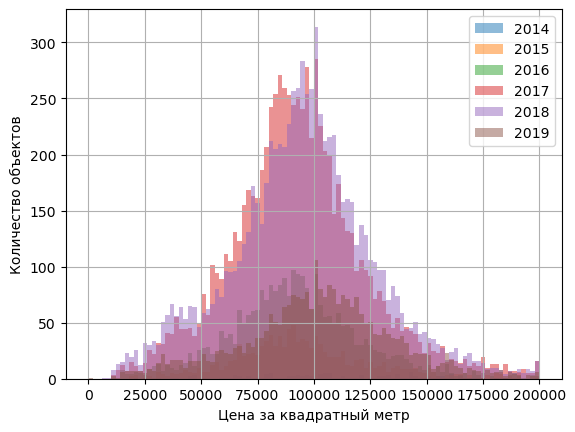

In [73]:
year = 2014
while year < 2020:
    data_weekday_month_year[data_weekday_month_year['year'] == year]['price_per_square_meter'].hist(bins=100, range=(0,200000), alpha=0.5)
    year += 1
plt.xlabel('Цена за квадратный метр')
plt.ylabel('Количество объектов')
plt.legend(['2014','2015','2016','2017','2018','2019'])


Наблюдаем незначительное смещение пика графиков в сторону увеличения цены за квадратный метр.

Text(0.5, 0, 'Год')

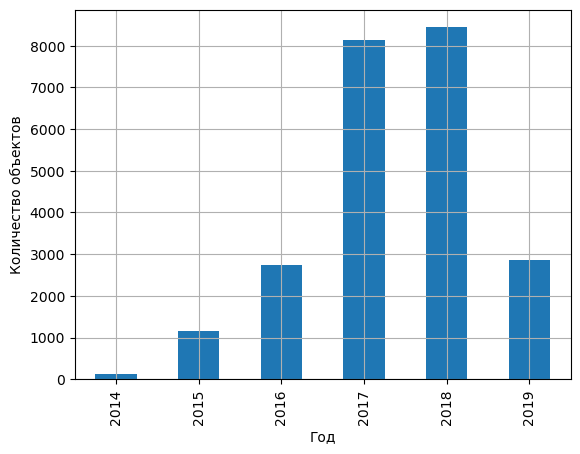

In [74]:
data_weekday_month_year.pivot_table(index='year', values='price_per_square_meter', aggfunc=['count']).plot(kind='bar',grid=True, legend = False)
plt.ylabel('Количество объектов')
plt.xlabel('Год')

**<font color="maroon">Шел рост количества объявлений с каждым годом, скорее всего это связано с развитием платформы яндекс.недвижимость. В 2019 году количество объявлений резко снизилось возможно из-за роста цен.</font>**

##### Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. #

In [75]:
top_10_locality_name = data['short_locality_name'].value_counts()[:10]
print(top_10_locality_name)
top_10_locality_name = top_10_locality_name.index
top_10_locality_name

short_locality_name
Санкт-Петербург    15626
Мурино               585
Кудрово              471
Шушары               439
Всеволожск           394
Пушкин               366
Колпино              336
Парголово            325
Гатчина              302
Выборг               235
Name: count, dtype: int64


Index(['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'Выборг'],
      dtype='object', name='short_locality_name')

In [76]:
top_10_pivot_table_mean = (data
                           .query('short_locality_name in @top_10_locality_name')
                           .pivot_table(index='short_locality_name', values='price_per_square_meter', aggfunc='mean')
                           .sort_values('price_per_square_meter', ascending=False))
top_10_pivot_table_mean

,price_per_square_meter
short_locality_name,
Санкт-Петербург,114760.099838
Пушкин,103147.825574
Кудрово,95326.179108
Парголово,90164.550646
Мурино,85988.321419
Шушары,78673.295877
Колпино,75500.165476
Гатчина,68636.425099
Всеволожск,68606.705152


In [77]:
top_10_pivot_table_min_max = (data
                              .query('short_locality_name in @top_10_locality_name')
                              .pivot_table(index='short_locality_name', values='price_per_square_meter', aggfunc=['min','max']))
top_10_pivot_table_min_max

,min,max
,price_per_square_meter,price_per_square_meter
short_locality_name,,
Всеволожск,31400.00,640422.35
Выборг,18750.00,107473.12
Гатчина,10507.25,146315.79
Колпино,47957.37,125000.00
Кудрово,54160.35,160401.00
Мурино,50000.00,138580.25
Парголово,39205.96,138522.43
Пушкин,59836.07,256521.74


Наиболее высокие значения показывает Санкт-Петербург, бюджетные объекты находятся в Выборге.

##### Зависимость цены от удаленности центра города #

                price_per_square_meter    km
km_from_center                              
0.0                      245833.530370   0.0
1.0                      177327.462304   1.0
2.0                      157874.408608   2.0
3.0                      121225.876877   3.0
4.0                      133419.743250   4.0
5.0                      140126.925699   5.0
6.0                      150059.670813   6.0
7.0                      156168.949976   7.0
8.0                      125008.849661   8.0
9.0                      113159.735094   9.0
10.0                     112790.555706  10.0
11.0                     108626.900154  11.0
12.0                     107437.306475  12.0
13.0                     108138.604282  13.0
14.0                     104212.625087  14.0
15.0                     104221.752926  15.0
16.0                     100526.969546  16.0
17.0                      96603.322370  17.0
18.0                      96415.427654  18.0
19.0                      98652.735732  19.0
20.0      

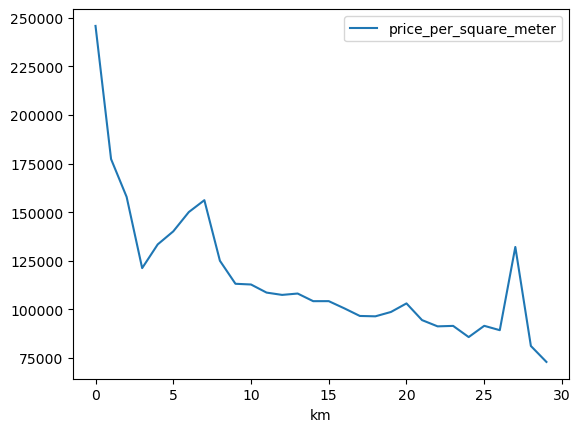

In [78]:
spb_data = data.query('locality_name == "Санкт-Петербург"')
spb_data['km_from_center'] = (spb_data['cityCenters_nearest']/1000).round()
spb_data['km_from_center'].value_counts().index
price_per_km = (spb_data
               .pivot_table(index='km_from_center', values='price_per_square_meter', aggfunc='mean'))
plot_price_per_km = price_per_km
plot_price_per_km['km'] = price_per_km.index
print(price_per_km)
plot_price_per_km.plot(x = 'km', y='price_per_square_meter' ,kind='line')
pd.options.mode.chained_assignment = None

Самые дорогие квартиры находятся  в радусе 2-3км от центра, далее идут скачки значений, вероятнее всего связаны с элитными(благоустроенными) районами города.  

В ходе исследовательского анализа данных можно выделить следующие выводы:  
-Наиболее популярные квартиры стоимостью 95 тыс. за кв.м.с как минимум одной комнатой, потолком в 2.7 метра и планировкой от 50 кв.м.
-Основные продажи квартир случаются в течении первых 4 месяцев.   
-На стоимость квартиры положительно влияет общая площадь, количество комнат, год продажи, отрицательно - количество комнат, удаленность от центра, день и месяц продажи.  
-Санкт-Петербург имеет самую большую стоимость и самую большую стоимость за кв.м.  
-Зависимость расстояния до центра и стоимости за кв.м. оправдана местоположением объекта


### Общий вывод

**При предобработке данных выявлено несколько аномалий:**  
1.В данных по жилой,общей и кухонной площади   
2.В данных по высоте потолков
Это могло произойти в следствии неправильного ввода данных пользователем. Количество таких объектов 130, что составляет 0.5% от всей выборки.

**На стадии анализа пропусков рассмотрено три группы:**  
1.Столбцы, которые можно восcтановить и необходимые для выставления гипотез  
2.Столбцы не влияющие для выставления гипотез  
3.Столбцы, значения которых невозможно корректно восстановить.

Так же выявлены ошибки при вводе данных о количестве этажей в доме, пользователи пропускали поле и вводили только этаж квартиры так как она находилась на последнем этаже.
Больше 90% пропусков в столбце 'is_apartment', говорит либо о ошибке либо о малом количестве аппартаментов в выборке.
Одинаковое количество пропусков в столбцах parks_around3000, ponds_around3000, cityCenters_nearest, airports_nearest, parks_nearest не в Санкт-Петербурге указывает на системную ошибку.

**Рекомедация по минимизации пропусков:**  
1)Автоматизация проставления повторяющихся значений в разных столбцах(как этажность объекта у квартир на последнем этаже)   
2)Помечать поля как обязательные для заполнения  
3)Проверять не заполненные поля перед размещением объявления

Было выполнено удаление дубликатов в названиях населенных пунктов.  
Был изменен тип данных для комфортного восприятия информации.  
В ходе предобработки исходный размер данных уменьшился на 0.93%. 

При рассмотрении зависимостей от количества объявлений выявлены наиболее популярные параметры объекта - Квартиры стоимостью 95 тыс. за кв.м.с как минимум одной комнатой, потолком в 2.7 метра и планировкой от 50 кв.м

**Главные параметры для оценки стоимости жилья:**  
    1)Стоимость за квадратный метр  
    2)Общая площадь квартиры и ее отношение к площади кухни и жилой площади помогают определить самый предпочтительный тип квартир 
    3)Удаленность от центра города и размещение объекта в крупном городе  
    4)Приоритетность размещения квартир не на первых и последних этажах
Даты продаж позволяют определить, когда лучше запускать рекламу. 